<a href="https://colab.research.google.com/github/iamujjawal23/Destiginfy.io/blob/main/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import cv2
import time
import json
from keras.models import Model , Sequential , load_model
from keras.layers import *
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions

In [ ]:
def readTextFile(file_path):
    with open(file_path) as f:
        return f.read()

# Correct path to your file
doc = readTextFile(r'/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

lines = doc.split("\n")[:-1]  # since last line is an empty string
print(len(lines))

40460


In [ ]:
lines[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
descriptions = {}

for line in lines:

    tokens = line.split('\t')

    # take the first token as image id, the rest as caption
    img_name , caption = tokens[0] , tokens[1]
    img_name = img_name.split('.')[0]

    # if image id is not present in dictionary then initialize it with empty list
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []

    descriptions[img_name].append(caption)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
len(descriptions)

8092

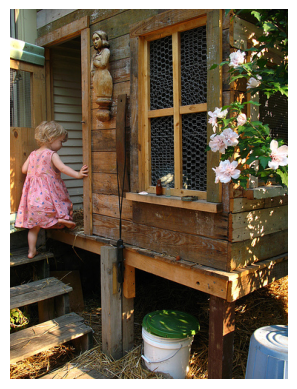

In [ ]:
img_path = "/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Images/"
img = cv2.imread(img_path+'1000268201_693b08cb0e'+'.jpg')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def clean_text(sentence):

    # convert to lower case
    sentence = sentence.lower()

    # remove punctuation and numbers from each token
    sentence = re.sub('[^a-z]+' , ' ' , sentence)

    # remove single characters like 's' and 'a'
    sentence = [word for word in sentence.split() if len(word)>1]
    sentence = " ".join(sentence)

    return sentence


for img_id , caption_list in descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = clean_text(caption_list[caption])

descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
with open("descriptions.txt" , "w") as f:
    f.write(str(descriptions))

In [ ]:
with open("descriptions.txt" , "r") as f:
    descriptions = f.read()

type(descriptions)

str

In [ ]:
json_acceptable_str = descriptions.replace("'" , "\"")

# loads() method is used to parse a valid JSON string and convert it into a Python Dictionary
descriptions = json.loads(json_acceptable_str)
type(descriptions)

dict

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
total_words = []

for key, caption_list in descriptions.items():
    [total_words.append(word) for caption in caption_list for word in caption.split()]

print("Total no of words across all image captions: %d" %(len(total_words)))

Total no of words across all image captions: 373837


In [ ]:
total_words[:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']

In [ ]:
unique_words = set()

for key in descriptions.keys():
    [unique_words.update(caption.split()) for caption in descriptions[key]]

print("Total no of unique words across all image captions: %d" %(len(unique_words)))

Total no of unique words across all image captions: 8424


In [ ]:
word_count_threshold = 10
freq_counts = {}

for word in total_words:
    freq_counts[word] = freq_counts.get(word , 0) + 1

print(len(freq_counts.keys()))

8424


In [ ]:
sorted_freq_count = sorted(freq_counts.items() , reverse = True , key = lambda x:x[1])

In [ ]:
print(sorted_freq_count[:10])

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643)]


In [ ]:
sorted_freq_count = [x for x in sorted_freq_count if x[1] > word_count_threshold]

vocabulary = [x[0] for x in sorted_freq_count]
print("Final Vocab Size: %d" %len(vocabulary))

Final Vocab Size: 1845


In [ ]:
train_file_data = readTextFile("/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
train_id = [id.split(".")[0] for id in train_file_data.split("\n")[:-1]]

In [ ]:
print("No of Image Id's in Train Data: %d" %len(train_id))

No of Image Id's in Train Data: 6000


In [ ]:
test_file_data[-1]

'\n'

In [ ]:
test_id = [id.split(".")[0] for id in test_file_data.split("\n")[:-1]]
print("No of Image Id's in Test Data: %d" %len(test_id))

No of Image Id's in Test Data: 1000


In [ ]:
# Prepare descriptions for the training data
# Tweak - Add 'start' and 'end' token to our training data
train_descriptions = {}

for img_id in train_id:
    train_descriptions[img_id] = []

    for caption in descriptions[img_id]:
        caption_to_append = "startseq "+caption+" endseq"
        train_descriptions[img_id].append(caption_to_append)

print("Train Descriptions: %d" %len(train_descriptions))

Train Descriptions: 6000


In [ ]:
train_descriptions = {}

for img_id in train_id:
    train_descriptions[img_id] = descriptions.get(img_id)

for key , caption_list in train_descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = 'startseq ' + caption_list[caption] + ' endseq'

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
model = ResNet50(weights = 'imagenet' , input_shape = (224, 224, 3))
model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
model_new = Model(model.input , model.layers[-2].output)
model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
def preprocess_image(img):
    img = image.load_img(img , target_size = (224, 224))
    img = image.img_to_array(img)

    # Converted from 3D to a 4D tensor i.e from (224, 224, 3) -- axis=0 --> (1, 224, 224, 3)
    img = np.expand_dims(img , axis = 0)

    # Images are converted from RGB to BGR
    # then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
    img = preprocess_input(img)
    return img

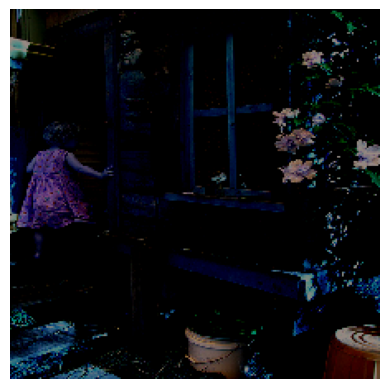

In [ ]:
im = preprocess_image(img_path+"1000268201_693b08cb0e.jpg")
plt.imshow(im[0]/255.0)
plt.axis('off')
plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)           # (1 X 2048)
    feature_vector = feature_vector.reshape((-1, ))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image(img_path+"1000268201_693b08cb0e.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([0.06536552, 0.16782713, 0.32518423, ..., 0.05111536, 0.3281793 ,
       1.0043337 ], dtype=float32)

In [ ]:
IMG_PATH = '/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Images/'

In [ ]:
start = time.time()
encoded_train_data = {}

for ix, img_id in enumerate(train_id):
    img_path = IMG_PATH + img_id + ".jpg"
    encoded_train_data[img_id] = encode_image(img_path)

    if ix%500 == 0:
        print("Encoding in Progress Step Time %d" %ix)

end = time.time()
print("Time Elapsed: " , end-start)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

In [ ]:
with open("encoded_train_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_train_data , file)

In [ ]:
 train_features = pickle.load(open("encoded_train_img_features.pkl", "rb"))
 print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
start = time.time()
encoded_test_data = {}

for ix, img_id in enumerate(test_id):
    img_path = IMG_PATH + img_id + ".jpg"
    encoded_test_data[img_id] = encode_image(img_path)

    if ix%500 == 0:
        print("Test Encoding in Progress Step Time %d" %ix)

end = time.time()
print("Time Elapsed: " , end-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Test Encoding in Progress Step Time 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
with open("encoded_test_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_test_data , file)

In [ ]:
with open("encoded_test_img_features.pkl" , "rb") as f:
    encoded_test_data = pickle.load(f)

In [ ]:
len(vocabulary)

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(vocabulary):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(word_to_idx['dog'])
print(idx_to_word[6])

6
dog


In [ ]:
word_to_idx['startseq'] = 1846
idx_to_word[1846] = 'startseq'

word_to_idx['endseq'] = 1847
idx_to_word[1847] = 'endseq'


# vocab size is len+1 because we will append 0's as well  ;  0th index will be reserved for zero padding
vocab_size = len(word_to_idx) + 1
print("Final Vocab Size: %d" %vocab_size)

Final Vocab Size: 1848


In [ ]:
max_len = 0

for key in descriptions.keys():
    for caption in descriptions[key]:
        max_len = max(max_len , len(caption.split()))

print('Max Description Length: %d' %max_len)

Max Description Length: 35


In [ ]:
def data_generator(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size):
    x1, x2, y = [], [], []
    n = 0

    while True:
        for key, caption_list in train_descriptions.items():
            n += 1
            photo = encoded_train_data[key]

            for caption in caption_list:
                seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]

                for i in range(1, len(seq)):
                    input_seq, output_seq = seq[0:i], seq[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_len, value=0, padding="post")[0]
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]

                    x1.append(photo)  # Photo feature vector
                    x2.append(input_seq)  # Partial caption input
                    y.append(output_seq)  # Output word as one-hot vector

            if n == batch_size:
                yield ((np.array(x1), np.array(x2)), np.array(y))  # Return a tuple
                x1, x2, y = [], [], []  # Reset for next batch
                n = 0


In [ ]:
def get_dataset(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size):
    generator = lambda: data_generator(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size)
    output_signature = (
        (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # x1
         tf.TensorSpec(shape=(None, max_len), dtype=tf.int32)),  # x2
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y
    )
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


In [ ]:
file = open("/content/drive/MyDrive/glove.6B.50d.txt", encoding="utf8")


In [ ]:
for line in file:
    print(line)
    break

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



In [ ]:
embeddings_index = {}   # embeddings for 6 billion words

for line in file:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:] , dtype = 'float')
    embeddings_index[word] = word_embedding

file.close()

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    embedding_matrix = np.zeros((vocab_size , emb_dim))

    for idx, word in idx_to_word.items():
        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
embeddings_matrix = get_embedding_matrix()
embeddings_matrix.shape

(1848, 50)

In [ ]:
# image feature extractor model
input_img_features = Input(shape = (2048,))   # ResNet 50 output
fe1 = Dropout(0.3)(input_img_features)
fe2 = Dense(256, activation='relu')(fe1)   # downsample image vector to 256 dim


# partial caption sequence model
input_captions = Input(shape = (max_len,))  # 33 dim
se1 = Embedding(vocab_size, 50, mask_zero=True)(input_captions)   # we will use pre-initialized embedding matrix
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)    # output text vector is 256 dim

# decoder (feed forward) model - contains info about both image and text vector of 256 dim
decoder1 = add([fe2 , se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)  # predicts prob dist over entire vocab

# merge the two input models - image features and encoded text captions
model = Model(inputs = [input_img_features, input_captions], outputs = outputs)

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 35, 50)         │         92,400 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 2048)           │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 35, 50)         │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_6 (NotEqual)    │ (None, 35)             │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        524,544 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 256)            │        314,368 │ dropout_13[0][0],      │
│                           │                        │                │ not_equal_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 256)            │              0 │ dense_18[0][0],        │
│                           │                        │                │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 256)            │         65,792 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 1848)           │        474,936 │ dense_19[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,472,040 (5.62 MB)

 Trainable params: 1,472,040 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [ ]:
len(train_descriptions)

6000

In [ ]:
epochs = 10
batch_size = 3
steps_per_epoch = len(train_descriptions)//batch_size

In [ ]:
# Assuming the generator function and other definitions are already implemented
for i in range(epochs):
    dataset = get_dataset(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size)
    model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - loss: 4.7687
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 3.6872
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 3.3851
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 3.2152
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 3.0932
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 3.0048
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.9330
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.8762
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 2.8288
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 2.7864


In [ ]:
j = 11
for i in range(epochs):
    dataset = get_dataset(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size)
    model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1)
    model.save('model_weights_' + str(j) + '.h5')
    j += 1


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.7513


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.7233


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.6972


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 2.6698


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.6498


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 2.6287


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 2.6117


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 2.5949


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - loss: 2.5841


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - loss: 2.5657


In [ ]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 6
steps_per_epoch = len(train_descriptions)//batch_size

In [ ]:
for i in range(epochs):
    dataset = get_dataset(train_descriptions, encoded_train_data, word_to_idx, max_len, batch_size, vocab_size)
    model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=1)
    model.save('model_weights_'+str(j)+'.h5')
    j += 1

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 2.5564


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.5180


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.4989


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 2.4838


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.4730


In [ ]:
#model = load_model('model_weights_25.h5')
model.load_weights('model_weights_25.h5')

In [ ]:
def predict_caption_using_greedySearch(photo):

    inp_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in inp_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence] , maxlen = max_len , padding = 'post')

        pred_label = model.predict([photo , sequence])
        pred_label = pred_label.argmax()      # Greedy Sampling : Word with max probability always
        pred_word = idx_to_word[pred_label]   # retreiving the word

        inp_text += " " + pred_word    # adding it to the sequence

        # if <e>/end sequence is encountered
        if pred_word == "endseq":
            break

    final_caption = inp_text.split(' ')[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


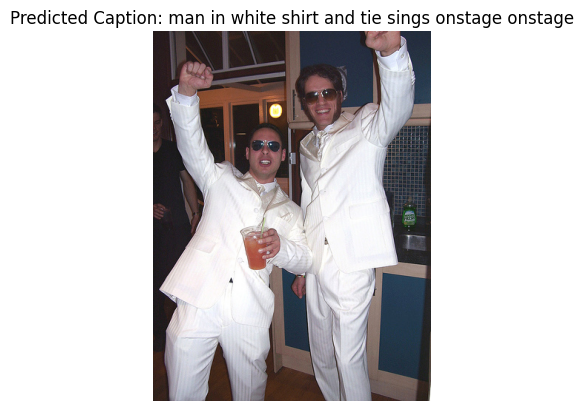

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


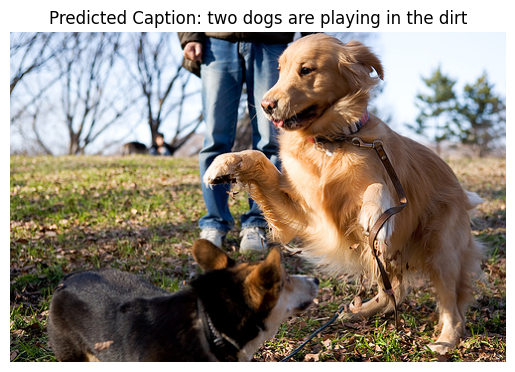

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


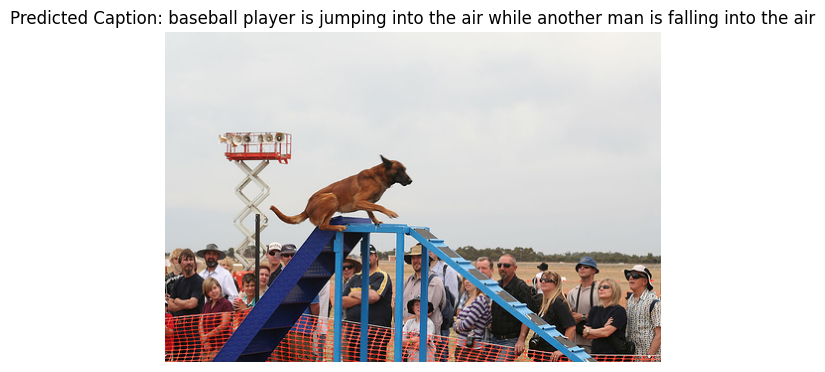

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


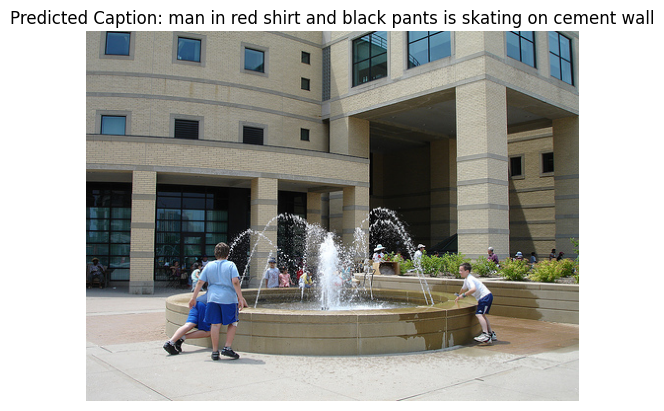

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


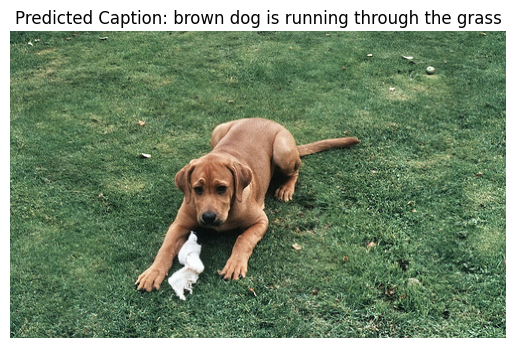

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


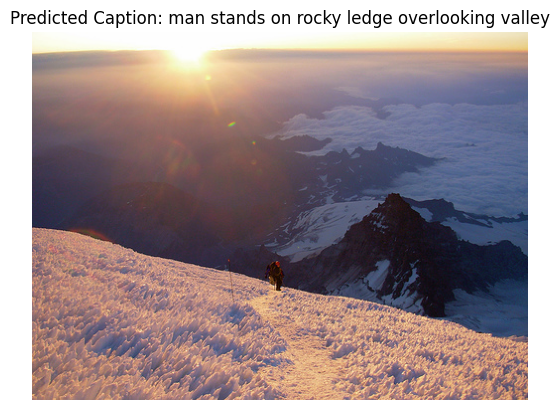

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


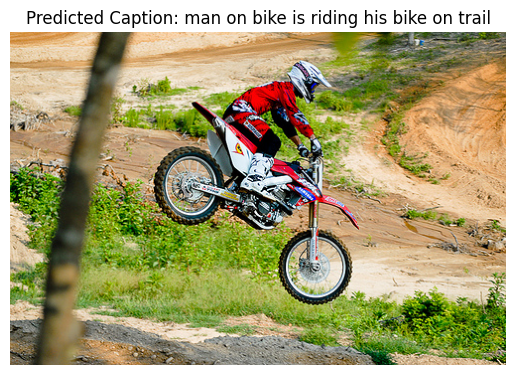

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


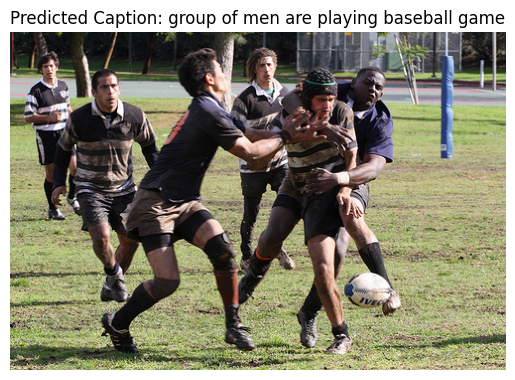

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


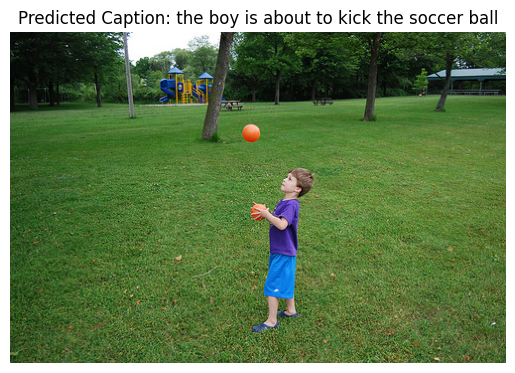

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


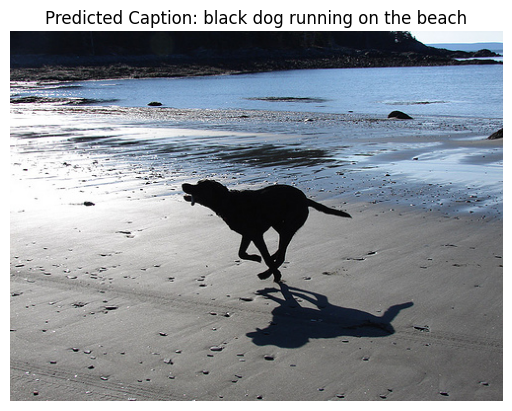

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


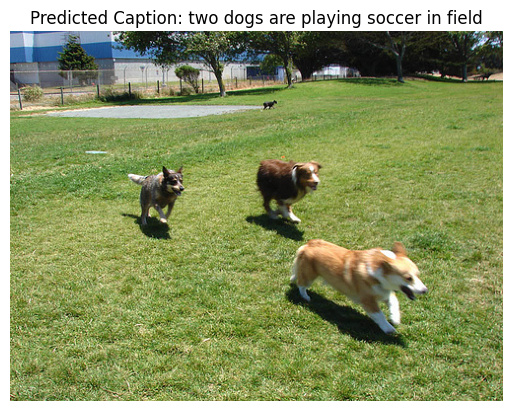

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


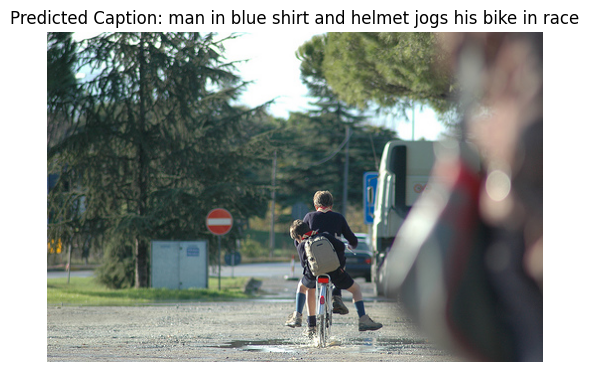

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


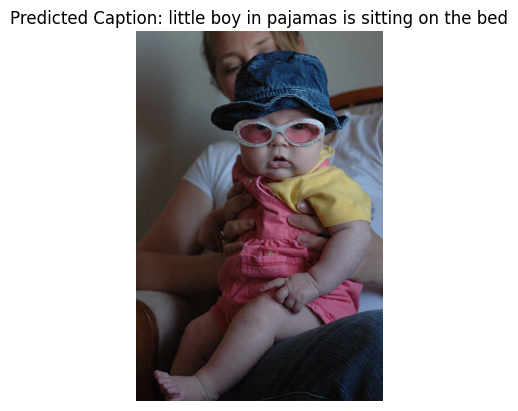

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


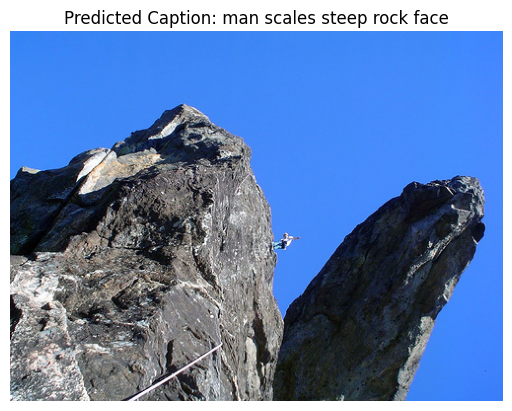

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


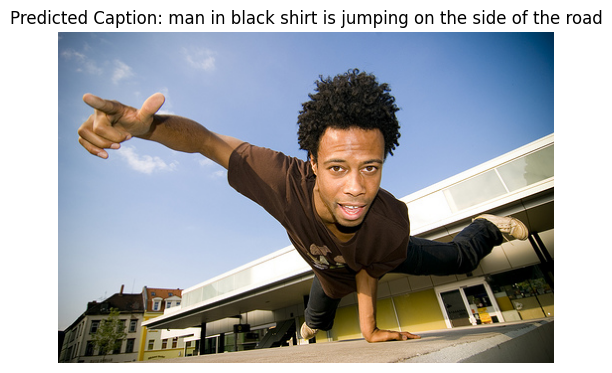

In [ ]:
IMG_PATH = '/content/drive/MyDrive/ml/Flickr_Data/Flickr_Data/Images/'

for i in range(15):
    idx = np.random.randint(0, 1000)

    all_test_images = list(encoded_test_data.keys())
    test_img_id = all_test_images[idx]
    test_img_vec = encoded_test_data[test_img_id].reshape((1, 2048))  # batch size x feature vector

    output_caption = predict_caption_using_greedySearch(test_img_vec)

    img = plt.imread(IMG_PATH + test_img_id + ".jpg")
    plt.imshow(img)
    plt.title("Predicted Caption: " + output_caption)
    plt.axis('off')
    plt.show()